In [1]:
#@markdown ## Set Up (reinicar entorno luego de completado)
%pip install --force-reinstall numpy==1.23.5

In [2]:
%pip install dowhy --quiet
import dowhy
import numpy as np
import pandas as pd

from graphviz import Digraph, Source
from scipy.stats import bernoulli

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.9/301.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.9/172.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 27.3 MB/s eta 0:00:00


# Introducción a la Inferencia Causal

# Ejercicios - Clase 2

Consideremos este ejemplo, extraído y modificado a partir del libro _Causality_ de Pearl.

Supongamos que tenemos un pequeño terreno cultivado con riego automático. La entrada al terreno puede estar mojada debido a la lluvia ($L = 1$) pero también debido a que se encendió el riego automático ($R = 1$).

Este grafo ilustra nuestras hipótesis sobre cómo se relacionan distintas variables: la estación del año actual ($E = 0$ es la temporada seca, $E=1$ la temporada húmeda), el si llovió o no hoy, el estado del sistema de riego, si el suelo está mojado ($M = 1$), y si está resbaladizo ($Y = 1$). Notemos que todas las variables en este caso son binarias (adoptan el valor $0$ o $1$ según un caso u otro).

En este caso, podríamos tomar $L = \text{lluvia}$ como nuestra variable de tratamiento, mientras que $Y = \text{resbaladizo}$ es el "resultado", y así preguntarnos qué efecto causal tiene la lluvia sobre el estado resbaladizo de la entrada al terreno.

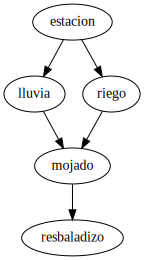

In [3]:
# No modificar
graph_dot_source = 'digraph {\
  lluvia;\
  estacion;\
  riego;\
  mojado;\
  resbaladizo;\
  estacion -> lluvia;\
  lluvia -> mojado; riego -> mojado;\
  mojado -> resbaladizo;\
  estacion -> riego;\
  }'
dot = Source(graph_dot_source)
dot

# Ejercicio 1

Implementar una red causal bayesiana que tenga a este DAG como grafo subyacente. Para eso, basarse en las siguientes tablas de probabilidad condicional (al igual que en el notebook principal de la clase 2):

\begin{align}
 p(E = 1) &= 0.5 \\
 p(L = 1 \mid E = 0) &= 0.3 \\
 p(L = 1 \mid E = 1) &= 0.65 \\
 p(R = 1 \mid E = 0) &= 0.4 \\
 p(R = 1 \mid E = 1) &= 0.2 \\
 p(M = 1 \mid L = l, R = r) &= \begin{cases}
  1 & \text{ si $l=1$ o $r=1$} \\
  0.1 & \text{ si $l=r=0$}
 \end{cases} \\
p(Y = 1 \mid M = 1) &= 1 \\
p(Y = 1 \mid M = 0) &= 0.1
\end{align}

Las intuiciones son:
* Se generarán tantas observaciones de estación húmeda como de estación seca.
* Hay más lluvia en estación húmeda, mientras que hay más riego en estación seca.
* Si llovió o hay riego, el suelo estará mojado, pero si no, también tiene una probabilidad baja de estar mojado por otras razones.
* Si el suelo está mojado, definitivamente estará resbaladizo, pero si no, también tiene una probabilidad baja de estar resbaladizo por otras razones.


El resultado debe ser una función `samplear_modelo(n)` que, dado $n$, devuelva un DataFrame de `pandas` con $n$ filas, donde cada fila es una muestra aleatoria $(e, l, r, m, y)$ de la distribución de probabilidad conjunta $p(E, L, R, M, Y)$. Los nombres de las columnas deben ser `['estacion', 'lluvia', 'riego', 'mojado', 'resbaladizo']`.

_Ayuda_: dado que todas las variables son binarias, las tablas de probabilidad se pueden implementar como distribuciones de Bernoulli en las que el parámetro $p$ (probabilidad de obtener $1$) sea una función de los valores de las variables padre. Por ejemplo, para la variable $E$, podemos definir

In [4]:
def samplear_E(n):
  return bernoulli.rvs(0.5, size=n)
def computar_L(es): # es : array de valores de e
  return np.array([bernoulli.rvs(0.3 if e == 0 else 0.65) for e in es])

### Respuesta


In [5]:
### Respuesta

def computar_R(es):
  return np.array([bernoulli.rvs(0.4 if e == 0 else 0.2) for e in es])

def computar_M(ls, rs):
  return ls | rs | bernoulli.rvs(0.1, size=len(rs))

def computar_Y(ms):
  return ms | bernoulli.rvs(0.1, size=len(ms))

def samplear_modelo(n):
  es = samplear_E(n)
  ls = computar_L(es)
  rs = computar_R(es)
  ms = computar_M(ls, rs)
  ys = computar_Y(ms)
  df = pd.DataFrame({'estacion': es,
                     'lluvia': ls,
                     'riego' : rs,
                     'mojado': ms,
                     'resbaladizo': ys})
  return df

# Ejercicio 2
Ahora que tenemos el modelo generativo, _olvidémonos_ de que lo conocemos e imaginemos distintas situaciones de disponibilidad de datos.

(a) Tenemos un dataset en el que todas las variables son observables. ¿Qué método de identificación puedo aplicar? ¿Cuál sería mi conjunto de ajuste y por qué?

(b) Ahora en cambio tenemos un dataset que omite las variables $E$ y $R$. Por ejemplo, consiste en observaciones que hizo alguien al pasar en auto cerca de la entrada al terreno, sin anotar la fecha ni fijarse en si el riego estaba o había sido activado hace poco). ¿Podemos aún así identificar el efecto causal con alguna de las herramientas vistas en la clase? ¿Por qué?

### Respuesta

In [6]:
print("Respuesta (a):", """
Podemos aplicar backdoor dado que condicionar en riego o en estación bloquea los caminos backdoor.
""")

print("Respuesta (b):", """
No podemos aplicar backdoor pero sí frontdoor.
""")


Respuesta (a): 
Podemos aplicar backdoor dado que condicionar en riego o en estación bloquea los caminos backdoor.

Respuesta (b): 
No podemos aplicar backdoor pero sí frontdoor.



# Ejercicio 3

Verificar nuestras respuestas con DoWhy. Para ello, vamos a usar el modelo generativo que construimos antes, en particular la función `samplear_modelo(n)`, que debe satisfacer lo pedido.

In [7]:
#@title Generación de datasets (no modificar) {display-mode: "form"}
dataset_a = samplear_modelo(10000)
dataset_b = samplear_modelo(10000).drop('estacion', axis=1).drop('riego', axis=1)

**Para cada uno de los dos datasets**:

1. Usando `dowhy`, inicializar un objeto `CausalModel` usando como DAG de hipótesis causales el DAG que presentamos más arriba.

> _Ayudas_:
> 1. Usen el _string_ de descripción del grafo con el cual lo visualizamos más arriba, a través de la variable `graph_dot_source`, y pasarle ese string al constructor de la clase `CausalModel`.
> 2. Para nombrar a las variables, usen siempre los nombres de las columnas del dataframe, que a su vez deben coincidir con los nombres de los nodos en el grafo (tal como aparecen en el string `graph_dot_source` que define el grafo).
> 3. Según la documentación de `dowhy`, cuando inicializamos el objeto `CausalModel` debemos pasarle el argumento opcional `proceed_when_unidentifiable=True` para asegurarnos de que no asuma la existencia de confusores no observados y nos permita identificar usando nuestro modelo (es decir, de esta forma se asume que nuestro modelo no omite confusores).

2. Pedir a `dowhy` que identifique el ATE y en caso de lograrlo, estimarlo a través del método de regresión lineal. Interpretar los resultados tanto del paso de identificación como del paso de estimación.

## Dataset (a)
### Respuesta

In [8]:
# Comenzar aquí el código de la respuesta

In [9]:
model_a = dowhy.CausalModel(dataset_a,
                            treatment='lluvia',
                            outcome='resbaladizo',
                            graph=graph_dot_source,
                            proceed_when_unidentifiable=True)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


In [10]:
identified_estimand = model_a.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                          
─────────(E[resbaladizo|riego])
d[lluvia]                      
Estimand assumption 1, Unconfoundedness: If U→{lluvia} and U→resbaladizo then P(resbaladizo|lluvia,riego,U) = P(resbaladizo|lluvia,riego)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡    d                      d              ⎤
E⎢─────────(resbaladizo)⋅─────────([mojado])⎥
 ⎣d[mojado]              d[lluvia]          ⎦
Estimand assumption 1, Full-mediation: mojado intercepts (blocks) all directed paths from lluvia to r,e,s,b,a,l,a,d,i,z,o.
Estimand assumption 2, First-stage-unconfoundedness: If U→{lluvia} and U→{mojado} then P(mojado|lluvia,U) = P(mojado|lluvia)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{mojado} and U→resbaladizo then P(resbaladizo|mojado, lluvia, U) = P(resbaladizo|moja

In [11]:
estimate = model_a.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 target_units="ate")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                          
─────────(E[resbaladizo|riego])
d[lluvia]                      
Estimand assumption 1, Unconfoundedness: If U→{lluvia} and U→resbaladizo then P(resbaladizo|lluvia,riego,U) = P(resbaladizo|lluvia,riego)

## Realized estimand
b: resbaladizo~lluvia+riego+lluvia*riego
Target units: ate

## Estimate
Mean value: 0.5569314171883887

Causal Estimate is 0.5569314171883887


In [12]:
estimate = model_a.estimate_effect(identified_estimand,
                                 method_name="frontdoor.linear_regression",
                                 target_units="ate")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: frontdoor
Estimand expression:
 ⎡    d                      d              ⎤
E⎢─────────(resbaladizo)⋅─────────([mojado])⎥
 ⎣d[mojado]              d[lluvia]          ⎦
Estimand assumption 1, Full-mediation: mojado intercepts (blocks) all directed paths from lluvia to r,e,s,b,a,l,a,d,i,z,o.
Estimand assumption 2, First-stage-unconfoundedness: If U→{lluvia} and U→{mojado} then P(mojado|lluvia,U) = P(mojado|lluvia)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{mojado} and U→resbaladizo then P(resbaladizo|mojado, lluvia, U) = P(resbaladizo|mojado, lluvia)

## Realized estimand
b: resbaladizo~lluvia+riego+lluvia*riego
Target units: ate

## Estimate
Mean value: 0.5569314171883887

Causal Estimate is 0.5569314171883887


Interpretación: el método backdoor puede aplicarse porque tanto condicionar en la estación como en el estado de riego permiten bloquear el camino backdoor. En este caso DoWhy propone la opción de condicionar sobre la variable de riego.

El método frontdoor también resulta aplicable dado que tenemos una variable, $\text{mojado}$, que media la totalidad del efecto causal buscado.

Las estimaciones para ambos estimandos causales resultan cercanas.

## Dataset (b)
### Respuesta

In [13]:
# Comenzar aquí el código de la respuesta

In [14]:
model_b = dowhy.CausalModel(dataset_b,
                            treatment='lluvia',
                            outcome='resbaladizo',
                            graph=graph_dot_source,
                            proceed_when_unidentifiable=True)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


In [15]:
identified_estimand = model_b.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡    d                      d              ⎤
E⎢─────────(resbaladizo)⋅─────────([mojado])⎥
 ⎣d[mojado]              d[lluvia]          ⎦
Estimand assumption 1, Full-mediation: mojado intercepts (blocks) all directed paths from lluvia to r,e,s,b,a,l,a,d,i,z,o.
Estimand assumption 2, First-stage-unconfoundedness: If U→{lluvia} and U→{mojado} then P(mojado|lluvia,U) = P(mojado|lluvia)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{mojado} and U→resbaladizo then P(resbaladizo|mojado, lluvia, U) = P(resbaladizo|mojado, lluvia)



In [16]:
estimate = model_b.estimate_effect(identified_estimand,
                                 method_name="frontdoor.linear_regression",
                                 target_units="ate")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: frontdoor
Estimand expression:
 ⎡    d                      d              ⎤
E⎢─────────(resbaladizo)⋅─────────([mojado])⎥
 ⎣d[mojado]              d[lluvia]          ⎦
Estimand assumption 1, Full-mediation: mojado intercepts (blocks) all directed paths from lluvia to r,e,s,b,a,l,a,d,i,z,o.
Estimand assumption 2, First-stage-unconfoundedness: If U→{lluvia} and U→{mojado} then P(mojado|lluvia,U) = P(mojado|lluvia)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{mojado} and U→resbaladizo then P(resbaladizo|mojado, lluvia, U) = P(resbaladizo|mojado, lluvia)

## Realized estimand
b: resbaladizo~lluvia
Target units: ate

## Estimate
Mean value: 0.5434454098980002

Causal Estimate is 0.5434454098980002


Interpretación: en este caso solo el método frontdoor estará disponible dado que las variables que bloquearían el camino backdoor no fueron observadas. Notar que se obtiene una estimación ligeramente menor del ATE que para el estimador frontdoor en el caso del dataset (a). Esto se debe a que en la regresión lineal no pudo incluirse un factor que contemplara la variable $\text{riego}$, a diferencia del caso previo, en el que eso sí era posible.

# Ejercicio 4

A partir de las hipótesis causales codificadas en el DAG y de los datos en el dataset (a), nos hacemos la preguntas:

1. ¿Cuál es la probabilidad de que el piso esté mojado si el riego no estaba encendido?
2. ¿Cuál es la probabilidad de que estemos en estación húmeda si el riego no estaba encendido?


3. Si hipotéticamente consideramos una situación en la que el sistema de riego fue retirado del terreno, _sin cambiar nada más_, ¿Cuál sería la probabilidad de que el piso esté mojado?
4. Todavía en esta situación hipotética, ¿Cuál sería la probabilidad de que estemos en estación húmeda?

Para cada pregunta, identificar cuál es la expresión matemática por la que nos estamos preguntando, y responder a la pregunta de manera numérica. Interpretar la relación entre las respuestas a 1 y 3 por un lado, y a 2 y 4 por el otro.

_Ayuda 1_: usar el dataset (a), o generar uno similar, para calcular frecuencias de ocurrencia de distintos eventos. Recordar que el dataset (a) había sido creado con un tamaño total de 10000 muestras.

_Ayuda 2_: si se necesita calcular cantidades intervencionales, escribir una nueva función `samplear_modelo_modificado(n)`, modificando la función `samplear_modelo(n)` que escribieron antes, respetando la regla de factorización truncada. Esto será muchísimo más fácil que usar `dowhy.gcm`, dado que se trata de variables aleatorias binarias y no es necesario ajustar ningún modelo a los datos.

### Respuesta

In [17]:
### Comenzar aquí la respuesta

Las expresiones a calcular son

1. $p(M = 1 \mid R = 0)$
2. $p(E = 1 \mid R = 0)$
3. $p(M = 1 \mid do(R = 0))$
4. $p(E = 1 \mid do(R = 0))$

In [18]:
respuesta_1 = (dataset_a[(dataset_a.riego == 0) & (dataset_a.mojado == 1)].shape[0]
              /dataset_a[dataset_a.riego == 0].shape[0])
print("La probabilidad de que el piso esté mojado si el riego",
      "no estaba encendido es", respuesta_1)

La probabilidad de que el piso esté mojado si el riego no estaba encendido es 0.5470800288392214


In [19]:
respuesta_2 = (dataset_a[(dataset_a.riego == 0) & (dataset_a.estacion == 1)].shape[0]
              /dataset_a[dataset_a.riego == 0].shape[0])
print("La probabilidad de que estemos en estación húmeda si el riego",
      "no estaba encendido es", respuesta_2)


La probabilidad de que estemos en estación húmeda si el riego no estaba encendido es 0.573323720259553


In [20]:
def samplear_modelo_modificado(n):
  es = samplear_E(n)
  ls = computar_L(es)
  rs = np.zeros((n), dtype=bool) # aquí está la intervención
  ms = computar_M(ls, rs)
  ys = computar_Y(ms)
  df = pd.DataFrame({'estacion': es,
                     'lluvia': ls,
                     'riego' : rs,
                     'mojado': ms,
                     'resbaladizo': ys})
  return df

In [21]:
dataset_intervenido = samplear_modelo_modificado(10000)
dataset_intervenido.head()

,estacion,lluvia,riego,mojado,resbaladizo
0,1,0,False,0,0
1,1,1,False,1,1
2,0,0,False,0,1
3,1,1,False,1,1
4,1,1,False,1,1


In [22]:
respuesta_3 = (dataset_intervenido[dataset_intervenido.mojado == 1].shape[0]
              /dataset_intervenido.shape[0])
print("La probabilidad de que el piso esté mojado en la situación hipotética en",
      "que el riego fue eliminado es", respuesta_3)

La probabilidad de que el piso esté mojado en la situación hipotética en que el riego fue eliminado es 0.5188


In [23]:
respuesta_4 = (dataset_intervenido[dataset_intervenido.estacion == 1].shape[0]
              /dataset_intervenido.shape[0])
print("La probabilidad de que estemos en estación húmeda en la situación",
      "hipotética en que el riego fue eliminado es", respuesta_4)

La probabilidad de que estemos en estación húmeda en la situación hipotética en que el riego fue eliminado es 0.5043


Interpretación:

Si condicionamos sobre que el riego no esté encendido, eso aumenta la evidencia de que estamos en estación húmeda (de un 50% a un 56%). En cambio, en la situación en la que simplemente sabemos que el sistema de riego no existe o no está en funcionamiento, este no está correlacionado directamente con la estación del año y por lo tanto la probabilidad de que sea estación húmeda o seca es la misma que en el caso en que no condicionamos (ni intervenimos) nada.

De esta forma se explica que las chances de que haya llovido en el primer caso son mayores a las que hay en el segundo, y por lo tanto, la probabilidad de que el suelo esté mojado también es ligeramente mayor (52.7% versus 51.8%).


